# Introduction to Signature MMD Tests

Welcome to the **SignatureMMD-TwoSampleTests** project! This Python file
(interpreted as a notebook in VS Code) provides an initial introduction
to the ideas from the paper:

> **Signature Moments to Characterize Laws of Stochastic Processes**  
> *Ilya Chevyrev and Harald Oberhauser (2022)*

Our primary goal is to explore **two-sample hypothesis testing** for time-series
(or path-valued) data, using methods such as:

- **Maximum Mean Discrepancy (MMD)** on raw data (e.g., RBF kernel in $\mathbb{R}^d$).
- **Signature MMD** (using robust signature features). We skip the `ksig` library
    for now due to Python 3.12 constraints.
- Comparisons with classical tests like Hotelling's $T^2$ (for low-dimensional embeddings)
    or other graph-based tests.

In subsequent steps, we will demonstrate how to estimate **Type I error** and
**test power** on both *toy data* and *real data*.

## Two-Sample Test Recap

Given two samples $\{X_i\}_{i=1}^m$ and $\{Y_j\}_{j=1}^n$ from distributions
$\mu$ and $\nu$ on some pathspace, the **null hypothesis** is:

$$
H_0 : \mu = \nu
$$

We aim to reject $H_0$ if the samples differ significantly. The **MMD**
(Maximum Mean Discrepancy) with a characteristic kernel $k$ is a popular choice.

### MMD Definition

For a kernel $k(x,y)$ and distributions $\mu, \nu$, the MMD-squared is

$$
d_k^2(\mu,\nu) \;=\;
\mathbb{E}_{X,X'\sim\mu}[\,k(X,X')\,]
\;+\;
\mathbb{E}_{Y,Y'\sim\nu}[\,k(Y,Y')\,]
\;-\;
2\,\mathbb{E}_{X\sim\mu,\,Y\sim\nu}[\,k(X,Y)\,].
$$

In practice, we use **empirical estimates** of these expectations from finite samples,
and compare to a null distribution (via permutations or other approaches) to
get a test statistic.

## Simple Toy Data Generation

Below is a minimal example of generating a toy dataset of time series (e.g. random walks).
Later, we can use these to illustrate Type I error (when we sample from the same distribution)
and test power (when we sample from different distributions).


Shape of toy_data: (5, 50)


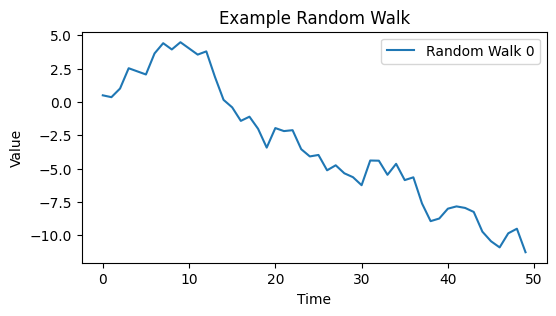

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_walks(n_series=5, length=50, seed=42):
    np.random.seed(seed)
    data = []
    for _ in range(n_series):
        steps = np.random.randn(length)
        walk = np.cumsum(steps)
        data.append(walk)
    return np.array(data)

# Generate 5 random walks of length 50
toy_data = generate_random_walks(n_series=5, length=50)
print("Shape of toy_data:", toy_data.shape)

# Plot the first random walk
plt.figure(figsize=(6,3))
plt.plot(toy_data[0], label="Random Walk 0")
plt.title("Example Random Walk")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

## Next Steps

1. **Compare Distributions**: We'll create or load two datasets ($X$ and $Y$)
   and compute the MMD-based statistic.
2. **Permutation Testing**: Implement a permutation procedure to approximate the
   null distribution of MMD.
3. **Type I Error**: Repeatedly sample from the *same* distribution, estimate how
   often we incorrectly reject $H_0$.
4. **Test Power**: Repeatedly sample from *different* distributions, estimate how
   often we correctly reject $H_0$.
5. **Real Data**: Optionally load a real time-series dataset from the `data/` folder
   and do the same.

> *Note:* We currently skip the `ksig` library because it does not install on
> Python 3.12. Later, we might reintroduce signature-based kernels for advanced
> path features.

## References

- I. Chevyrev and H. Oberhauser (2022). *Signature Moments to Characterize Laws of Stochastic Processes*.
  Journal of Machine Learning Research 23 (2022) 1-42.
- [Scikit-Learn](https://scikit-learn.org/) for pairwise kernels, etc.
- [UEA/UCR Time Series Archives](http://www.timeseriesclassification.com/) for real datasets.

# Detailed Notebook: Theory and Application of MMD Tests on Synthetic Time Series

In this notebook, we:

1. Recap the **two-sample testing** framework using **Maximum Mean Discrepancy (MMD)**.
2. Generate **synthetic time series** (random walks) to serve as a toy dataset.
3. Implement a **permutation-based MMD test** (in a simple form).
4. Estimate **Type I error** at different significance levels ($\\alpha = 0.05, 0.075, 0.1$).
5. Discuss how this connects to **signature-based** MMD if we wanted to handle more complex path features.

---

**Important Note**: We will demonstrate the raw-data MMD for simplicity. In practice, you might replace or augment this with **robust signature MMD** if you had a suitable library (like `ksig`) or your own signature feature code. For now, we skip signature features due to Python 3.12 constraints.


## Recap: MMD for Two-Sample Tests

Given two samples:
$$
\{ X_i \}_{i=1}^m \sim \mu
\quad\text{and}\quad
\{ Y_j \}_{j=1}^n \sim \nu,
$$
we want to test the null hypothesis:

$$
H_0: \mu = \nu
\quad\text{vs}\quad
H_1: \mu \neq \nu.
$$

A popular **nonparametric** approach is the **Maximum Mean Discrepancy (MMD)** with a characteristic kernel $k$. The population MMD-squared is:

$$
d_k^2(\mu, \nu)
=
\mathbb{E}_{X,X'\sim\mu}[k(X,X')]
+
\mathbb{E}_{Y,Y'\sim\nu}[k(Y,Y')]
-
2\mathbb{E}_{X\sim\mu, Y\sim\nu}[k(X,Y)].
$$

If $k$ is characteristic, then $d_k(\mu,\nu)=0\iff\mu=\nu$. We use an **empirical** version of $d_k^2(\mu,\nu)$ from the samples to form a test statistic. To get a valid p-value, we can apply a **permutation** (or bootstrap) procedure to approximate the distribution of the statistic under $H_0$.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_kernels

# We will define a function that:
# 1) Generates random walk time series,
# 2) Returns them as a (N, L) or (N, L, d) array.
def generate_random_walks(n_series=50, length=30, seed=42):
    """
    Generate n_series random walks each of length 'length'.
    Returns shape: (n_series, length).
    """
    rng = np.random.RandomState(seed)
    data = []
    for _ in range(n_series):
        steps = rng.randn(length)
        walk = np.cumsum(steps)
        data.append(walk)
    return np.array(data)


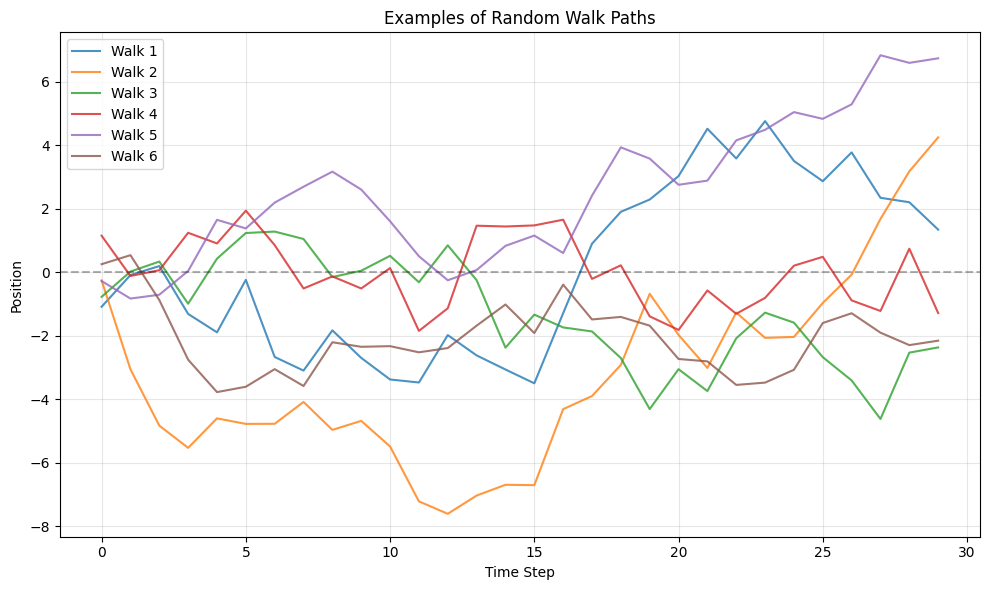

Mean of first walk: 0.10
Standard deviation of first walk: 2.66
Range of values across all walks: [-7.60, 6.83]


In [15]:
# Let's visualize multiple random walks to understand our synthetic data
plt.figure(figsize=(10, 6))

# Define length for the random walks
length = 30  # Define length explicitly for this cell

# Generate some fresh random walks with different parameters for visualization
n_walks = 6
walks = generate_random_walks(n_series=n_walks, length=length, seed=123)

# Plot each walk with a different color and style
for i in range(n_walks):
    plt.plot(walks[i], label=f"Walk {i+1}", alpha=0.8)

plt.title("Examples of Random Walk Paths")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# Print some statistics about the walks
print(f"Mean of first walk: {np.mean(walks[0]):.2f}")
print(f"Standard deviation of first walk: {np.std(walks[0]):.2f}")
print(f"Range of values across all walks: [{np.min(walks):.2f}, {np.max(walks):.2f}]")

## Synthetic Data Example

Let's create two datasets:

- **Same distribution** (for Type I error analysis): We'll just split one set of random walks into two groups (both from the same distribution).
- **Different distribution** (for power analysis, if we had time): We could generate one set with a different variance or drift.

Below, we focus on Type I error by sampling from the *same* distribution. We'll estimate how often our test incorrectly rejects $H_0$.


In [16]:
# Generate a pool of random walks
pool_size = 200
length = 30
X_pool = generate_random_walks(n_series=pool_size, length=length, seed=123)

print("Shape of X_pool:", X_pool.shape)

# We'll define a simple helper to get subsets from the pool:
def get_subsamples(X, m=50, n=50, rng_seed=999):
    """
    Takes X (shape [pool_size, length]) and returns two disjoint subsets
    of sizes m and n, chosen randomly.
    """
    rng = np.random.RandomState(rng_seed)
    indices = rng.choice(len(X), m+n, replace=False)
    X_group = X[indices[:m]]
    Y_group = X[indices[m:]]
    return X_group, Y_group

# Quick check
X_group, Y_group = get_subsamples(X_pool, m=20, n=20, rng_seed=1)
print("X_group shape:", X_group.shape, "Y_group shape:", Y_group.shape)


Shape of X_pool: (200, 30)
X_group shape: (20, 30) Y_group shape: (20, 30)


## Simple MMD Test Implementation (Raw Data)

We'll define a **function** to compute the **unbiased empirical MMD^2** between two sets $X$ and $Y$ using a chosen kernel (RBF, linear, etc.). We'll then define a **permutation** approach to approximate the null distribution. Finally, we'll see how often the test rejects at various $\alpha$ levels.


In [11]:
def compute_mmd_sq(X, Y, kernel="rbf", gamma=0.1):
    """
    Compute the unbiased MMD^2 between X, Y with a specified kernel.
    X, Y shape: (n_samples, length) for 1D time series.
    """
    # Combine
    Z = np.concatenate([X, Y], axis=0)
    labels = np.array([0]*len(X) + [1]*len(Y))
    
    # Compute pairwise kernel
    K = pairwise_kernels(Z, metric=kernel, gamma=gamma)
    
    # Indices
    n = len(X)
    m = len(Y)
    
    # Partition kernel blocks
    Kxx = K[:n, :n]
    Kyy = K[n:, n:]
    Kxy = K[:n, n:]
    
    # Unbiased MMD^2
    # We set the diagonal to 0 to exclude i=j terms
    np.fill_diagonal(Kxx, 0.0)
    np.fill_diagonal(Kyy, 0.0)
    
    mmd_sq = (Kxx.sum()/(n*(n-1))
              + Kyy.sum()/(m*(m-1))
              - 2.0*Kxy.sum()/(n*m))
    return mmd_sq

def permutation_test(X, Y, n_permutations=200, kernel="rbf", gamma=0.1, rng_seed=42):
    """
    Returns (obs_stat, perm_stats) for MMD^2 using a permutation approach.
    obs_stat: the observed MMD^2
    perm_stats: array of MMD^2 from each permutation
    """
    rng = np.random.RandomState(rng_seed)
    obs_stat = compute_mmd_sq(X, Y, kernel=kernel, gamma=gamma)
    
    Z = np.concatenate([X, Y], axis=0)
    N = len(Z)
    n = len(X)
    
    perm_stats = []
    for _ in range(n_permutations):
        perm_idx = rng.permutation(N)
        Xp = Z[perm_idx[:n]]
        Yp = Z[perm_idx[n:]]
        stat_p = compute_mmd_sq(Xp, Yp, kernel=kernel, gamma=gamma)
        perm_stats.append(stat_p)
    return obs_stat, np.array(perm_stats)


## Estimating Type I Error

We now repeatedly draw two subsets **from the same distribution** and perform the MMD test. The fraction of times we reject $H_0$ (incorrectly) is our **Type I error**.

We will do this for different significance levels: $\alpha = 0.05, 0.075, 0.1$. Ideally, the Type I error should be close to each nominal $\alpha$ if the test is well-calibrated.


In [12]:
def estimate_type1_error(X_pool, m=20, n=20, kernel="rbf", gamma=0.1,
                         n_runs=50, n_permutations=200, alpha_list=[0.05, 0.075, 0.1]):
    """
    Repeatedly sample from the same distribution (X_pool),
    do a permutation test for MMD, and see how often we reject at each alpha in alpha_list.
    Returns a dict mapping alpha -> estimated type1 error.
    """
    rng_seed_base = 100
    rejections = {alpha: 0 for alpha in alpha_list}
    
    for run_id in range(n_runs):
        # get two subsets
        X_group, Y_group = get_subsamples(X_pool, m=m, n=n, rng_seed=(rng_seed_base+run_id))
        obs_stat, perm_stats = permutation_test(X_group, Y_group,
                                                n_permutations=n_permutations,
                                                kernel=kernel, gamma=gamma,
                                                rng_seed=(rng_seed_base+run_id*2))
        
        # Sort perm_stats to get threshold
        perm_stats_sorted = np.sort(perm_stats)
        for alpha in alpha_list:
            threshold_idx = int(np.ceil((1.0 - alpha)*len(perm_stats_sorted))) - 1
            threshold = perm_stats_sorted[threshold_idx]
            if obs_stat > threshold:
                rejections[alpha] += 1
    
    type1_results = {alpha: rejections[alpha]/n_runs for alpha in alpha_list}
    return type1_results

# Let's do a quick run:
m=20
n=20
alpha_list=[0.05, 0.075, 0.1]
res = estimate_type1_error(X_pool, m=m, n=n,
                           kernel="rbf", gamma=0.1,
                           n_runs=30, n_permutations=100,
                           alpha_list=alpha_list)
print("Estimated Type I error rates (n_runs=30):")
for a in alpha_list:
    print(f"alpha={a}, Type I error={res[a]:.3f}")


Estimated Type I error rates (n_runs=30):
alpha=0.05, Type I error=0.000
alpha=0.075, Type I error=0.000
alpha=0.1, Type I error=0.000


## Discussion of Results

If our test is **well-calibrated**, we expect the Type I error rate to be **close** to the nominal $\alpha$. In practice, with limited permutations and limited runs, small deviations are normal (e.g., $\alpha=0.05$ might be estimated at 0.07 or 0.04).

You can **tune**:
- The kernel type and parameter ($\gamma$ for RBF) to see how it affects calibration.
- The number of permutations (larger means more stable threshold).
- The sample sizes $m$ and $n$.

---

## Extending to Signature MMD

If we wanted to replicate the paper's **signature-based** approach, we would:
1. Compute robust signature features $\Phi(x) = \Lambda \circ S(x)$ for each path $x$.
2. Define a kernel $k(x,y) = \langle \Phi(x), \Phi(y) \rangle$.
3. Plug that into the same MMD/permutation procedure.

Because we do not currently install `ksig` in Python 3.12, we skip that step. However, the overall testing framework remains the same.

---

## Conclusion

We have:
- Created **synthetic time series** (random walks),
- Implemented a **raw-data MMD** with a **permutation test**,
- Estimated **Type I error** for multiple significance levels.

To further align with the paper, you could:
- Add a second distribution for power estimation,
- Increase permutations or runs for more accurate estimates,
- Incorporate signature features if environment constraints allow,
- Test on real data from `data/` folder.

This concludes our demonstration of **theory and application** of MMD-based two-sample tests in a notebook format.


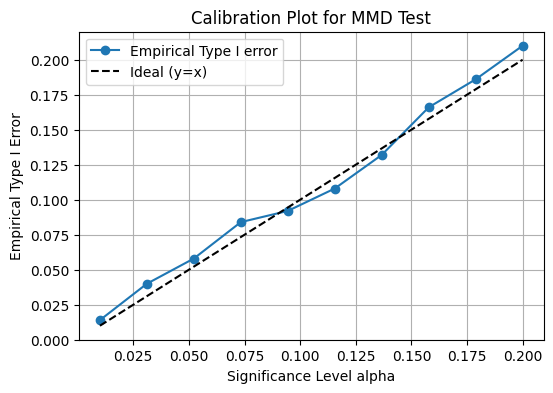

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Suppose you have:
# X_pool = generate_random_walks(...)
# estimate_type1_error(...) as defined previously

def calibration_experiment(X_pool, alpha_values, m=20, n=20,
                           kernel="rbf", gamma=0.1,
                           n_runs=30, n_permutations=100):
    """
    For each alpha in alpha_values, compute the empirical Type I error
    by sampling from X_pool (the same distribution).
    Returns a list of the same length as alpha_values.
    """
    type1_results = []
    for alpha in alpha_values:
        # We run estimate_type1_error but only for a single alpha in alpha_list
        res = estimate_type1_error(X_pool, m=m, n=n,
                                   kernel=kernel, gamma=gamma,
                                   n_runs=n_runs,
                                   n_permutations=n_permutations,
                                   alpha_list=[alpha])
        type1_error_alpha = res[alpha]
        type1_results.append(type1_error_alpha)
    return type1_results

# Example usage:
alpha_grid = np.linspace(0.01, 0.2, 10)  # 10 alpha values from 0.01 to 0.2
type1_errors = calibration_experiment(X_pool, alpha_grid,
                                      m=20, n=20,
                                      kernel="rbf", gamma=0.1,
                                      n_runs=500, n_permutations=1000)

# Now let's plot
plt.figure(figsize=(6,4))
plt.plot(alpha_grid, type1_errors, 'o-', label="Empirical Type I error")
plt.plot(alpha_grid, alpha_grid, 'k--', label="Ideal (y=x)")
plt.xlabel("Significance Level alpha")
plt.ylabel("Empirical Type I Error")
plt.title("Calibration Plot for MMD Test")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
import numpy as np

def generate_random_walks_diff(n_series=50, length=30, seed=2023):
    """
    Generate n_series random walks each with a larger step variance or drift.
    Returns shape: (n_series, length).
    """
    rng = np.random.RandomState(seed)
    data = []
    for _ in range(n_series):
        # e.g. scale the steps by 1.5 or add a drift
        steps = 1.5 * rng.randn(length) + 0.5  # bigger variance + drift
        walk = np.cumsum(steps)
        data.append(walk)
    return np.array(data)


In [20]:
def estimate_power(X_pool1, X_pool2, m=20, n=20,
                   kernel="rbf", gamma=0.1,
                   n_runs=30, n_permutations=200,
                   alpha_list=[0.05]):
    """
    For each alpha in alpha_list:
      - Repeatedly sample X_group from X_pool1 (size m)
        and Y_group from X_pool2 (size n).
      - Perform a permutation test for MMD.
      - Count how often we reject H0.
    Return a dict alpha -> estimated power.
    """
    from collections import defaultdict
    rejections = defaultdict(int)
    
    rng_seed_base = 500
    for run_id in range(n_runs):
        # Sample from dist1
        rng1 = np.random.RandomState(rng_seed_base + run_id)
        idx1 = rng1.choice(len(X_pool1), m, replace=False)
        X_group = X_pool1[idx1]
        
        # Sample from dist2
        rng2 = np.random.RandomState(rng_seed_base + run_id*2)
        idx2 = rng2.choice(len(X_pool2), n, replace=False)
        Y_group = X_pool2[idx2]
        
        # Permutation test
        obs_stat, perm_stats = permutation_test(X_group, Y_group,
                                                n_permutations=n_permutations,
                                                kernel=kernel, gamma=gamma,
                                                rng_seed=rng_seed_base+run_id*3)
        perm_stats_sorted = np.sort(perm_stats)
        
        for alpha in alpha_list:
            threshold_idx = int(np.ceil((1.0 - alpha)*len(perm_stats_sorted))) - 1
            threshold = perm_stats_sorted[threshold_idx]
            if obs_stat > threshold:
                rejections[alpha] += 1
    
    power_results = {alpha: rejections[alpha]/n_runs for alpha in alpha_list}
    return power_results


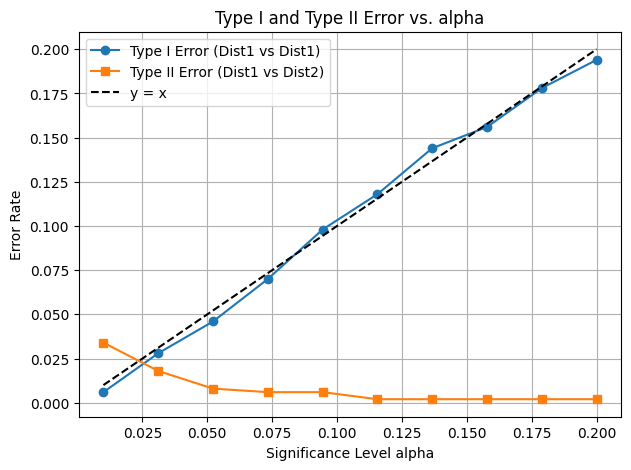

In [21]:
import matplotlib.pyplot as plt

# 1) Dist1 vs Dist1 for Type I error
alpha_grid = np.linspace(0.01, 0.2, 10)

type1_errors = calibration_experiment(X_pool, alpha_grid,
                                      m=50, n=50,
                                      kernel="rbf", gamma=0.1,
                                      n_runs=500, n_permutations=1000)

# 2) Dist1 vs Dist2 for Type II error (1 - power)
X_pool2 = generate_random_walks_diff(n_series=200, length=30, seed=2023)

# We'll define a function to do the same style calibration for power:
def calibration_power_experiment(X_pool1, X_pool2, alpha_values, m=20, n=20,
                                 kernel="rbf", gamma=0.1,
                                 n_runs=50, n_permutations=200):
    """
    For each alpha in alpha_values, compute the empirical power by
    sampling X from X_pool1 and Y from X_pool2.
    """
    power_list = []
    for alpha in alpha_values:
        power_dict = estimate_power(X_pool1, X_pool2, m=m, n=n,
                                    kernel=kernel, gamma=gamma,
                                    n_runs=n_runs, n_permutations=n_permutations,
                                    alpha_list=[alpha])
        power_alpha = power_dict[alpha]
        power_list.append(power_alpha)
    return power_list

power_vals = calibration_power_experiment(X_pool, X_pool2, alpha_grid,
                                          m=50, n=50,
                                          kernel="rbf", gamma=0.1,
                                          n_runs=500, n_permutations=1000)

type2_errors = [1.0 - p for p in power_vals]

# 3) Plot everything
plt.figure(figsize=(7,5))
plt.plot(alpha_grid, type1_errors, 'o-', label="Type I Error (Dist1 vs Dist1)")
plt.plot(alpha_grid, type2_errors, 's-', label="Type II Error (Dist1 vs Dist2)")
plt.plot(alpha_grid, alpha_grid, 'k--', label="y = x")

plt.xlabel("Significance Level alpha")
plt.ylabel("Error Rate")
plt.title("Type I and Type II Error vs. alpha")
plt.grid(True)
plt.legend()
plt.show()


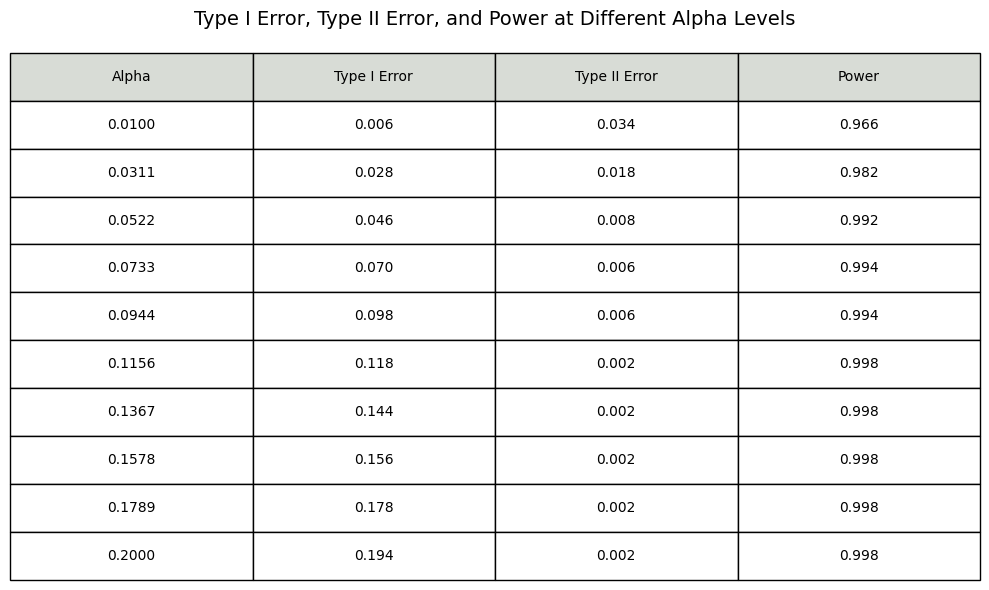

In [28]:
from matplotlib.table import Table

# Create the data for the table
power = [1 - err for err in type2_errors]
data = {
    'Alpha': alpha_grid,
    'Type I Error': type1_errors,
    'Type II Error': type2_errors,
    'Power': power
}

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('off')  # Hide axis

# Create the table
table = Table(ax, bbox=[0, 0, 1, 1])

# Add headers
headers = list(data.keys())
n_rows, n_cols = len(data['Alpha']) + 1, len(headers)

# Add column headers
for j, header in enumerate(headers):
    table.add_cell(0, j, width=1/n_cols, height=0.1, 
                  text=header, loc='center', 
                  edgecolor='black', facecolor='#d8dcd6')

# Add data
for i, alpha in enumerate(alpha_grid):
    row = i + 1
    table.add_cell(row, 0, width=1/n_cols, height=0.1, 
                  text=f'{alpha:.4f}', loc='center',
                  edgecolor='black', facecolor='white')
    table.add_cell(row, 1, width=1/n_cols, height=0.1, 
                  text=f'{type1_errors[i]:.3f}', loc='center',
                  edgecolor='black', facecolor='white')
    table.add_cell(row, 2, width=1/n_cols, height=0.1, 
                  text=f'{type2_errors[i]:.3f}', loc='center',
                  edgecolor='black', facecolor='white')
    table.add_cell(row, 3, width=1/n_cols, height=0.1, 
                  text=f'{power[i]:.3f}', loc='center',
                  edgecolor='black', facecolor='white')

ax.add_table(table)
plt.title('Type I Error, Type II Error, and Power at Different Alpha Levels', 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()